# Sentence Embedding - Présentation générale

* Ce notebook présente différentes techniques de "Sentence Embeddings", permettant de générer des features à partir de phrases (ici des tweets)
* L'objectif est de pouvoir séparer les sentiments des tweets de façon automatique, via un T-SNE, qui permet une réduction des features en 2 dimensions
* C'est un notebook d'exemples afin de mieux comprendre la mise en oeuvre des techniques. Il n'est pas optimisé et doit être adapté à un nouveau contexte, en particulier sur les points suivants :
    * Le nettoyage des textes
    * les modèles BERT (model_type) idéalement pré-entraînés sur des données similaires au contexte (ici le modèle 'cardiffnlp/twitter-roberta-base-sentiment' surperforme le modèle de base car il a été pré-entraîné sur des tweets)
    * La taille des vecteurs (max_length)
    * Le batch_size
    * La perplexité du Tsne (perplexity à 30 par défaut)

# Préparation initiale dataset

## Récupération du dataset et filtres de données

In [2]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Fichier des tweets à récupérer sur : https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

data_T0 = pd.read_csv("QueryResultsFinal.csv")
print(data_T0.shape)

(66769, 12)


In [34]:
data_T0 = data_T0.iloc[:500,]

In [35]:
l_cat = list(set(data_T0['main_tag']))

y_cat_num = [(1-l_cat.index(data_T0.iloc[i]['main_tag'])) for i in range(len(data_T0))]

In [36]:
data_T0.head(10)

,Title,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount,body_clean,main_tag,ActivityTime,sentence_bow,sentence_bow_lem,sentence_dl
0,How to convert Decimal to Double in C#?,"['c#', 'floating-point', 'type-conversion', 'd...",4,795,72107,13,2008-07-31 21:42:52,2022-09-08 05:07:26,4,want assign decimal variable double variable d...,c#,5151,want assign decimal variable double variable d...,want assign decimal variable double variable d...,want assign decimal variable double variable d...
1,Calculate relative time in C#,"['c#', 'datetime', 'time', 'datediff', 'relati...",11,1645,198982,41,2008-07-31 23:55:37,2022-09-05 11:26:30,3,given specific value display relative time lik...,c#,5148,given specific value display relative time lik...,given specific value display relative time lik...,given specific value display relative time lik...
2,Determine a user's timezone,"['html', 'browser', 'timezone', 'user-agent', ...",13,704,285740,27,2008-08-01 00:42:38,2022-03-29 07:31:31,10,standard way web server able determine user ti...,html,4988,standard way web server able determine user ti...,standard way web server able determine user ti...,standard way web server able determine user ti...
3,How to use the C socket API in C++ on z/OS,"['c++', 'c', 'sockets', 'mainframe', 'zos']",25,175,15977,9,2008-08-01 12:13:50,2023-06-01 11:20:00,1,issue getting c socket work properly c althoug...,c++,5416,issue getting socket work properly although in...,issue getting socket work properly although in...,issue getting c socket work properly c althoug...
4,Decoding T-SQL CAST in C#/VB.NET,"['c#', 'sql', 'vb.net', 'ascii', 'hex']",109,68,6106,2,2008-08-01 15:23:05,2019-02-10 22:11:00,3,recently site deluged resurgence botnet inject...,c#,3845,recently site deluged resurgence botnet inject...,recently site deluged resurgence botnet inject...,recently site deluged resurgence botnet inject...
5,What is the meaning of the type safety warning...,"['java', 'generics', 'warnings', 'casting', 't...",382,81,10087,1,2008-08-02 08:58:27,2021-11-02 07:46:01,1,meaning java warning type safety cast object a...,java,4839,meaning java warning type safety cast object a...,meaning java warning type safety cast object a...,meaning java warning type safety cast object a...
6,Best way to access Exchange using PHP?,"['php', 'windows', 'exchange-server', 'webdav'...",588,58,59724,9,2008-08-03 00:03:58,2020-07-13 09:02:05,2,writing cm application one requirement must ab...,php,4362,writing application one requirement must able ...,writing application one requirement must able ...,writing cm application one requirement must ab...
7,cx_Oracle: How do I iterate over a result set?,"['python', 'sql', 'database', 'oracle', 'cx-or...",594,55,58540,3,2008-08-03 01:15:08,2016-10-15 20:47:11,1,several way iterate result set,python,2995,several way iterate result set,several way iterate result set,several way iterate result set
8,.NET testing framework advice,"['c#', '.net', 'visual-studio', 'unit-testing'...",709,55,6704,10,2008-08-03 14:53:53,2020-07-30 10:57:38,1,looking introduce unit testing framework mix j...,c#,4378,looking introduce unit testing framework mix j...,looking introduce unit testing framework mix j...,looking introduce unit testing framework mix j...
9,How to create a new object instance from a Type,"['c#', '.net', 'performance', 'reflection', 't...",752,908,710040,11,2008-08-03 16:29:03,2022-11-16 07:35:48,1,one may always know type object may need creat...,c#,5217,one may always know type object may need creat...,one may always know type object may need creat...,one may always know type object may need creat...


## Nettoyage du texte

In [37]:
# Vérifier si la colonne "Colonne1" contient des valeurs float
float_values = data_T0['body_clean'][data_T0['body_clean'].apply(lambda x: isinstance(x, float))]
print(float_values)

Series([], Name: body_clean, dtype: object)


In [11]:
data_T0.drop(19729, inplace=True)

In [38]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

data_T0['sentence_bow'] = data_T0['body_clean'].apply(lambda x : transform_bow_fct(x))
data_T0['sentence_bow_lem'] = data_T0['body_clean'].apply(lambda x : transform_bow_lem_fct(x))
data_T0['sentence_dl'] = data_T0['body_clean'].apply(lambda x : transform_dl_fct(x))
data_T0.shape

C:\Users\Oliver\AppData\Local\Temp\ipykernel_16440\3851584904.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T0['sentence_bow'] = data_T0['body_clean'].apply(lambda x : transform_bow_fct(x))
C:\Users\Oliver\AppData\Local\Temp\ipykernel_16440\3851584904.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_T0['sentence_bow_lem'] = data_T0['body_clean'].apply(lambda x : transform_bow_lem_fct(x))
C:\Users\Oliver\AppData\Local\Temp\ipykernel_16440\3851584904.py:64: SettingWithCopyWarning: 
A valu

(500, 15)

In [14]:
data_T0.head(10)

,Title,Tags,Id,Score,ViewCount,AnswerCount,CreationDate,LastActivityDate,CommentCount,body_clean,main_tag,ActivityTime,sentence_bow,sentence_bow_lem,sentence_dl
0,How to convert Decimal to Double in C#?,"['c#', 'floating-point', 'type-conversion', 'd...",4,795,72107,13,2008-07-31 21:42:52,2022-09-08 05:07:26,4,want assign decimal variable double variable d...,c#,5151,want assign decimal variable double variable d...,want assign decimal variable double variable d...,want assign decimal variable double variable d...
1,Calculate relative time in C#,"['c#', 'datetime', 'time', 'datediff', 'relati...",11,1645,198982,41,2008-07-31 23:55:37,2022-09-05 11:26:30,3,given specific value display relative time lik...,c#,5148,given specific value display relative time lik...,given specific value display relative time lik...,given specific value display relative time lik...
2,Determine a user's timezone,"['html', 'browser', 'timezone', 'user-agent', ...",13,704,285740,27,2008-08-01 00:42:38,2022-03-29 07:31:31,10,standard way web server able determine user ti...,html,4988,standard way web server able determine user ti...,standard way web server able determine user ti...,standard way web server able determine user ti...
3,How to use the C socket API in C++ on z/OS,"['c++', 'c', 'sockets', 'mainframe', 'zos']",25,175,15977,9,2008-08-01 12:13:50,2023-06-01 11:20:00,1,issue getting c socket work properly c althoug...,c++,5416,issue getting socket work properly although in...,issue getting socket work properly although in...,issue getting c socket work properly c althoug...
4,Decoding T-SQL CAST in C#/VB.NET,"['c#', 'sql', 'vb.net', 'ascii', 'hex']",109,68,6106,2,2008-08-01 15:23:05,2019-02-10 22:11:00,3,recently site deluged resurgence botnet inject...,c#,3845,recently site deluged resurgence botnet inject...,recently site deluged resurgence botnet inject...,recently site deluged resurgence botnet inject...
5,What is the meaning of the type safety warning...,"['java', 'generics', 'warnings', 'casting', 't...",382,81,10087,1,2008-08-02 08:58:27,2021-11-02 07:46:01,1,meaning java warning type safety cast object a...,java,4839,meaning java warning type safety cast object a...,meaning java warning type safety cast object a...,meaning java warning type safety cast object a...
6,Best way to access Exchange using PHP?,"['php', 'windows', 'exchange-server', 'webdav'...",588,58,59724,9,2008-08-03 00:03:58,2020-07-13 09:02:05,2,writing cm application one requirement must ab...,php,4362,writing application one requirement must able ...,writing application one requirement must able ...,writing cm application one requirement must ab...
7,cx_Oracle: How do I iterate over a result set?,"['python', 'sql', 'database', 'oracle', 'cx-or...",594,55,58540,3,2008-08-03 01:15:08,2016-10-15 20:47:11,1,several way iterate result set,python,2995,several way iterate result set,several way iterate result set,several way iterate result set
8,.NET testing framework advice,"['c#', '.net', 'visual-studio', 'unit-testing'...",709,55,6704,10,2008-08-03 14:53:53,2020-07-30 10:57:38,1,looking introduce unit testing framework mix j...,c#,4378,looking introduce unit testing framework mix j...,looking introduce unit testing framework mix j...,looking introduce unit testing framework mix j...
9,How to create a new object instance from a Type,"['c#', '.net', 'performance', 'reflection', 't...",752,908,710040,11,2008-08-03 16:29:03,2022-11-16 07:35:48,1,one may always know type object may need creat...,c#,5217,one may always know type object may need creat...,one may always know type object may need creat...,one may always know type object may need creat...


In [16]:
data_T0.to_csv("QuerySaveAfterLem.csv")

# Préparation commune des traitements

In [17]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


## Lecture dataset

In [39]:
data_T = data_T0

## Fonctions communes

In [40]:
import time

# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des tweets par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des tweets par clusters')
    
    plt.show()
    print("ARI : ", ARI)


# Bag of word - Tf-idf

## Préparation sentences

In [41]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])

## Exécution des modèles

In [42]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(ctf_transform)

CountVectorizer : 
-----------------
ARI :  0.014 time :  2.0

Tf-idf : 
--------
ARI :  0.025 time :  2.0


## Graphiques

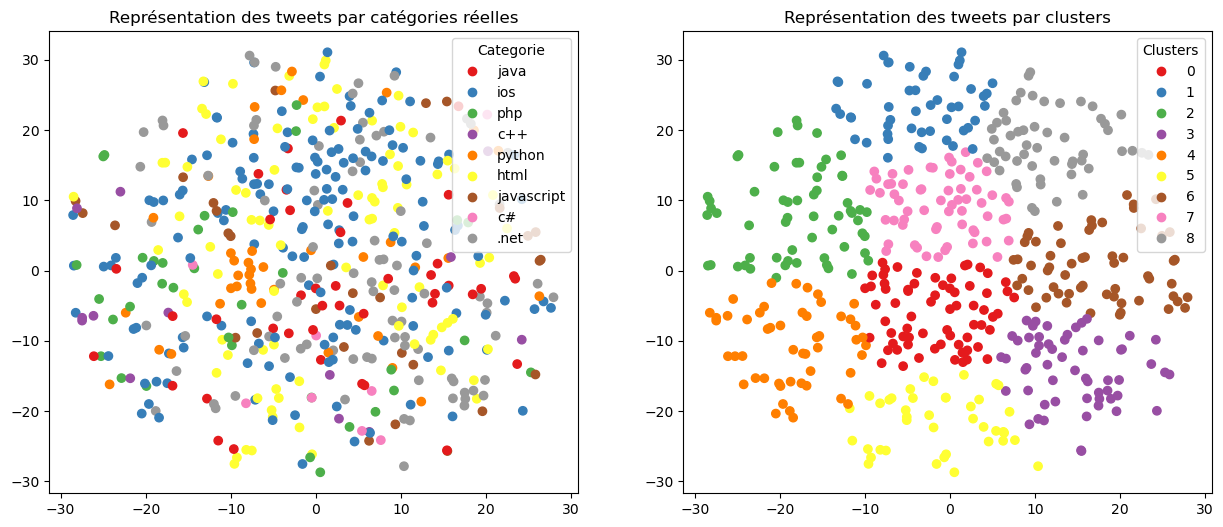

ARI :  0.025


In [43]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# Word2Vec

In [16]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

ModuleNotFoundError: No module named 'tensorflow'

## Création du modèle Word2Vec

In [46]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 24 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [47]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4816
Word2Vec trained


In [48]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4817


## Création de la matrice d'embedding

In [49]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4817, 300)


## Création du modèle d'embedding

In [50]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 24, 300)           1445100   
                                                                 
 global_average_pooling1d_1   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 1,445,100
Trainable params: 1,445,100
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [51]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(3000, 300)

In [52]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.5298 time :  30.0


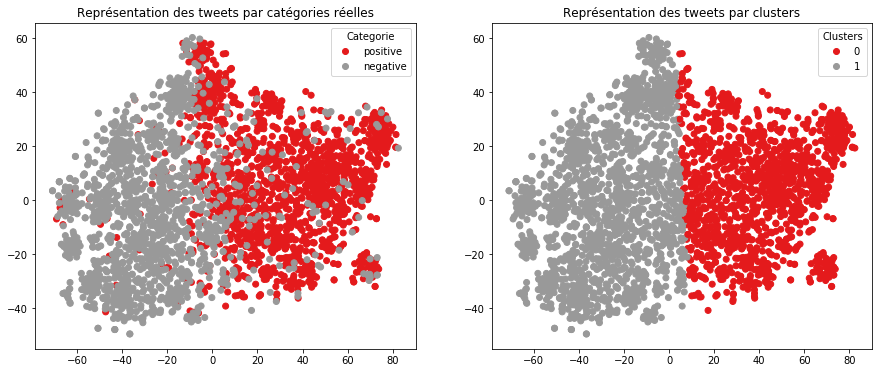

ARI :  0.5298


In [53]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# BERT

In [13]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [17]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

NameError: name 'tf' is not defined

## Fonctions communes

In [15]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

### 'bert-base-uncased'

In [16]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

In [17]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

temps traitement :  60.0


In [18]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.6177 time :  31.0


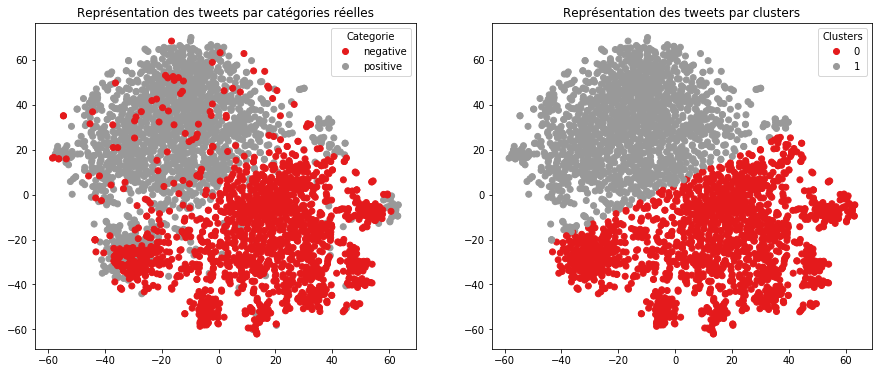

ARI :  0.6177


In [19]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 'cardiffnlp/twitter-roberta-base-sentiment'
* Modèle pré-entraîné sur des tweets pour l'analyse de sentiment = particulièrement adapté au contexte

In [20]:
max_length = 64
batch_size = 10
model_type = 'cardiffnlp/twitter-roberta-base-sentiment'
model = TFAutoModel.from_pretrained(model_type)
sentences = data_T['sentence_dl'].to_list()

In [21]:
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

temps traitement :  61.0


In [22]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.8836 time :  37.0


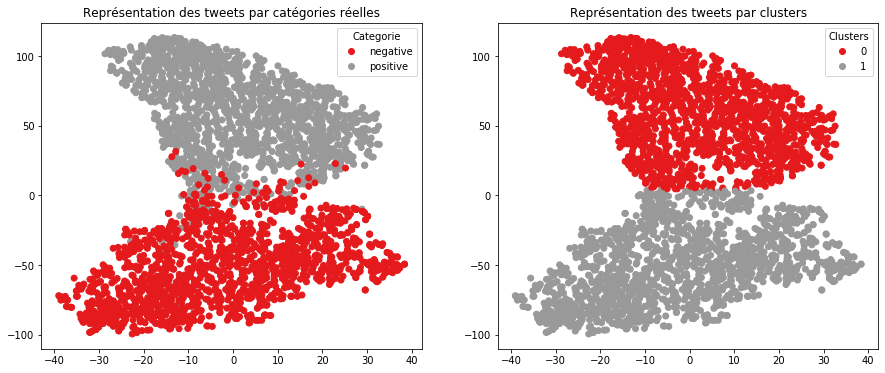

ARI :  0.8836


In [23]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## BERT hub Tensorflow

In [25]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [26]:
sentences = data_T['sentence_dl'].to_list()

In [27]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  47.0


In [28]:
ARI, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.5805 time :  32.0


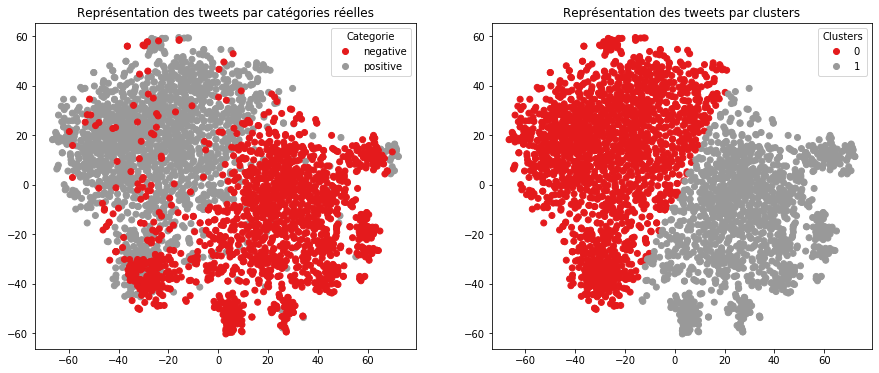

ARI :  0.5805


In [29]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

# USE - Universal Sentence Encoder

In [30]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [31]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.7.0
2.7.0
Num GPUs Available:  1
True


In [32]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [33]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [34]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [35]:
features_USE = feature_USE_fct(sentences, batch_size)

In [36]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.7315 time :  29.0


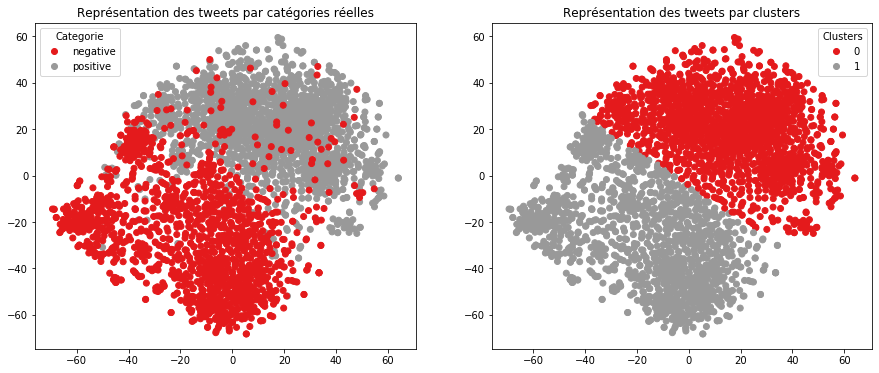

ARI :  0.7315


In [37]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)